In [2]:
import warnings, os
warnings.filterwarnings("ignore")

from copy import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, AggMapNet, loadmap
from aggmap.AggMapNet import load_model, save_model
from aggmap import show


#grey: #999999
np.random.seed(666) #just for reaptable results


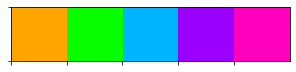

In [3]:
c = sns.color_palette('hsv', 8, desat=1).as_hex()
my_color = [c[0], c[2], c[4], c[6], c[7]]
sns.palplot(my_color)

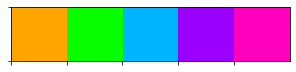

In [4]:
sns.palplot(my_color)

In [5]:
my_color, c

(['#ffa500', '#08ff00', '#00b5ff', '#9b00ff', '#ff00bd'],
 ['#ffa500',
  '#b3ff00',
  '#08ff00',
  '#00ff9d',
  '#00b5ff',
  '#0010ff',
  '#9b00ff',
  '#ff00bd'])

In [6]:
disease_colormap = {'cirrhosis': '#ffa500', 
                    'ibd':'#08ff00', 
                    't2d':'#00b5ff', 
                    'obesity':'#9b00ff' , 
                    'crc':'#ff00bd'}

In [7]:
clade_colormap = {'Lachnospiraceae': '#ff005c',
 'Clostridiaceae': '#f589d9',
 'Ruminococcaceae': '#9904f6',
 'Eubacterium': '#2204f9',
 'Peptostreptococcaceae': '#00b5ff',
 'Veillonellaceae': '#04eff6',
 'Streptococcaceae': '#00ff9d',
 'Bacteroidaceae': '#b3ff00',
 'Rikenellaceae': '#f0c40f',
 'Porphyromonadaceae': '#f84b0a',
 'Proteobacteria': '#cc0000',
 'Actinobacteria': '#ffa500'}

In [8]:
pd.Series(clade_colormap)

Lachnospiraceae          #ff005c
Clostridiaceae           #f589d9
Ruminococcaceae          #9904f6
Eubacterium              #2204f9
Peptostreptococcaceae    #00b5ff
Veillonellaceae          #04eff6
Streptococcaceae         #00ff9d
Bacteroidaceae           #b3ff00
Rikenellaceae            #f0c40f
Porphyromonadaceae       #f84b0a
Proteobacteria           #cc0000
Actinobacteria           #ffa500
dtype: object

In [9]:
from  aggmap.utils.gen_nwk import mp2newick, dfs_to_weightless_newick

In [10]:
top = 30

In [11]:
cirrhosis1 = pd.read_csv('../Cirrhosis_results/feature_imp_results.csv', index_col=0)
cirrhosis = cirrhosis1.sort_values('avg_imp', ascending=False)[['v', 'avg_imp']].head(top)
cirrhosis = cirrhosis.set_index('v')
cirrhosis['avg_imp'] = cirrhosis['avg_imp'].round(3)

ibd1 = pd.read_csv('../IBD_results/feature_imp_results.csv', index_col=0)
ibd = ibd1.sort_values('avg_imp', ascending=False)[['v', 'avg_imp']].head(top)
ibd['avg_imp'] = ibd['avg_imp'].round(3)
ibd = ibd.set_index('v')

t2d1 = pd.read_csv('../T2D_results/feature_imp_results.csv', index_col=0)
t2d = t2d1.sort_values('avg_imp', ascending=False)[['v', 'avg_imp']].head(top)
t2d['avg_imp'] = t2d['avg_imp'].round(3)
t2d = t2d.set_index('v')

obesity1 = pd.read_csv('../Obesity_results/feature_imp_results.csv', index_col=0)
obesity = obesity1.sort_values('avg_imp', ascending=False)[['v', 'avg_imp']].head(top)
obesity['avg_imp'] = obesity['avg_imp'].round(3)
obesity = obesity.set_index('v')

crc1 = pd.read_csv('../CRC_results/feature_imp_results.csv', index_col=0)
crc = crc1.sort_values('cancer_avg_imp', ascending=False)[['v', 'cancer_avg_imp']].head(top)
crc['avg_imp'] = crc['cancer_avg_imp'].round(3)
crc = crc.set_index('v')


In [12]:
uni = set(cirrhosis.index) | set(ibd.index) | set(t2d.index) | set(obesity.index) | set(crc.index) 
uni = list(uni)

In [13]:
df = pd.DataFrame([], index=uni)
df = df.join(cirrhosis1.set_index('v')['avg_imp'].to_frame(name = 'cirrhosis'))
df = df.join(ibd1.set_index('v')['avg_imp'].to_frame(name = 'ibd'))
df = df.join(t2d1.set_index('v')['avg_imp'].to_frame(name = 't2d'))
df = df.join(obesity1.set_index('v')['avg_imp'].to_frame(name = 'obesity'))
df = df.join(crc1.set_index('v')['cancer_avg_imp'].to_frame(name = 'crc'))

df = df.fillna(0)
df = df[df > 0].fillna(0)

In [14]:
df

,cirrhosis,ibd,t2d,obesity,crc
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_unclassified,0.000000,0.000000,0.000000,0.938736,0.000000
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum,0.000000,0.000000,0.000000,1.563421,0.000000
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia|s__Adlercreutzia_equolifaciens,0.630938,0.000000,3.624741,0.000000,2.191944
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens,1.083213,1.025686,0.961357,0.113544,2.977225
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_unclassified,0.000000,0.000000,2.195263,0.000000,1.414266
...,...,...,...,...,...
k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,1.169662,0.220465,0.749603,2.613542,0.000000
k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_unclassified,0.978286,0.406778,1.856035,0.929964,0.267298
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,0.081534,0.000000,2.338176,0.000000,1.758786
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parainfluenzae,7.086851,0.000000,0.224469,0.000000,2.331963


In [15]:
level_dict = {'k':'kingdom', 'p':'phylum', 'c':'class' ,'o':'order' ,'f':'family' ,'g': 'genus','s': 'species'}
dfs = pd.Series(df.index).apply(lambda x: dict([i.split('__') for i in x.split('|')])).apply(pd.Series)
dfs = dfs.rename(columns=level_dict)
dfs

,kingdom,phylum,class,order,family,genus,species
0,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Micrococcaceae,Rothia,Rothia_unclassified
1,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium_bifidum
2,Bacteria,Actinobacteria,Actinobacteria,Coriobacteriales,Coriobacteriaceae,Adlercreutzia,Adlercreutzia_equolifaciens
3,Bacteria,Actinobacteria,Actinobacteria,Coriobacteriales,Coriobacteriaceae,Collinsella,Collinsella_aerofaciens
4,Bacteria,Actinobacteria,Actinobacteria,Coriobacteriales,Coriobacteriaceae,Olsenella,Olsenella_unclassified
...,...,...,...,...,...,...,...
96,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Sutterella,Sutterella_wadsworthensis
97,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfovibrionales,Desulfovibrionaceae,Bilophila,Bilophila_unclassified
98,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia,Escherichia_coli
99,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,Haemophilus_parainfluenzae


In [16]:
nwk_string = dfs_to_weightless_newick(dfs)
with open( "tree.imp_genotype.nwk", "w") as f:
    f.write(nwk_string)

In [17]:
dfs.groupby('class').size().sort_values()

class
Deinococci              1
Deltaproteobacteria     1
Fusobacteriia           1
Verrucomicrobiae        1
Betaproteobacteria      2
Erysipelotrichia        2
Gammaproteobacteria     2
Actinobacteria          5
Bacilli                 5
Negativicutes           7
Bacteroidia            30
Clostridia             44
dtype: int64

In [18]:
level = 'class'
so = dfs.groupby(level).size() 
md = {}
for i, j in so.items():
    if j <= 2:
        md[i] = 'Others'
    else:
        md[i] = i

res = dfs[level].map(md)

In [19]:
colormap = dict(zip(res.unique(), c))
colormap

{'Actinobacteria': '#ffa500',
 'Bacteroidia': '#b3ff00',
 'Others': '#08ff00',
 'Bacilli': '#00ff9d',
 'Clostridia': '#00b5ff',
 'Negativicutes': '#0010ff'}

In [20]:
clade = res.map(colormap)
clade.index = dfs.species

In [21]:
clade.to_csv('1.csv')

In [22]:
df.index  = dfs.species
df.round(3).to_csv('tree_data_bar.csv')

In [23]:
df

,cirrhosis,ibd,t2d,obesity,crc
species,,,,,
Rothia_unclassified,0.000000,0.000000,0.000000,0.938736,0.000000
Bifidobacterium_bifidum,0.000000,0.000000,0.000000,1.563421,0.000000
Adlercreutzia_equolifaciens,0.630938,0.000000,3.624741,0.000000,2.191944
Collinsella_aerofaciens,1.083213,1.025686,0.961357,0.113544,2.977225
Olsenella_unclassified,0.000000,0.000000,2.195263,0.000000,1.414266
...,...,...,...,...,...
Sutterella_wadsworthensis,1.169662,0.220465,0.749603,2.613542,0.000000
Bilophila_unclassified,0.978286,0.406778,1.856035,0.929964,0.267298
Escherichia_coli,0.081534,0.000000,2.338176,0.000000,1.758786


5.575094936324811

<AxesSubplot:>

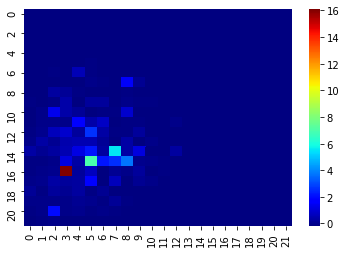

In [64]:
sns.heatmap(obesity1.avg_imp.values.reshape(loadmap('../Obesity_results/agg.mp').fmap_shape), cmap = 'jet',)

<AxesSubplot:>

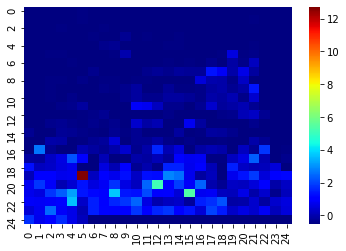

In [63]:
sns.heatmap(t2d1.avg_imp.values.reshape(loadmap('../T2D_results/agg.mp').fmap_shape), cmap = 'jet', 
            )

<AxesSubplot:>

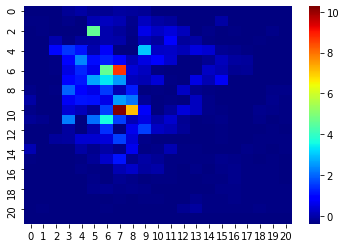

In [62]:
sns.heatmap(ibd1.avg_imp.values.reshape(loadmap('../IBD_results/agg.mp').fmap_shape), cmap = 'jet' )

<AxesSubplot:>

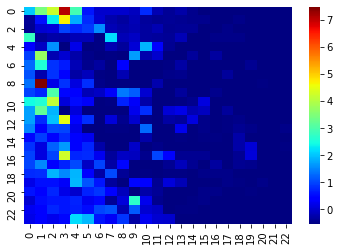

In [61]:
sns.heatmap(cirrhosis1.avg_imp.values.reshape(loadmap('../Cirrhosis_results/agg.mp').fmap_shape), cmap = 'jet')

<AxesSubplot:>

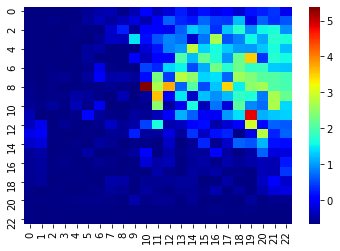

In [33]:
sns.heatmap(crc1.cancer_avg_imp.values.reshape(loadmap('../CRC_results/agg.mp').fmap_shape), cmap = 'jet',  )

